In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:

import tensorflow as tf
import numpy as np 
import matplotlib 
import os
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, BatchNormalization , ReLU, LeakyReLU, Dropout,Reshape
from keras.optimizers import Adam
import cv2

import matplotlib.pyplot as plt
from tqdm import tqdm


Using TensorFlow backend.


In [0]:
def discriminator():
	model = Sequential()
	model.add(Conv2D(8, (3,3) , strides= (2,2), padding= 'same',input_shape = (256,256,3)))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))

#128*128*8
	
	model.add(Conv2D(16, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization( momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#64*64*16

	model.add(Conv2D(32, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#32*32*32

	model.add(Conv2D(64, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#16*16*64

	model.add(Conv2D(128, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.25))
#8*8*128
	model.add(Conv2D(256, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.25))
#4*4*256
	model.add(Flatten())
	model.add(Dense(128))
	model.add(LeakyReLU(0.2))


	model.add(Dense(1,activation ='sigmoid'))
	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)
	model.compile(optimizer= optimus, loss = 'binary_crossentropy',metrics=['accuracy'])

	return model



In [0]:
def generator(latent_dim):
	model = Sequential()
	model.add(Dense((4096),input_dim = latent_dim))
	model.add(Reshape((1,1,4096)))

	model.add(Conv2DTranspose(512, (4,4) , strides=(2,2), padding='same'))
	model.add(ReLU())
#2*2*512
	model.add(Conv2DTranspose(256,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.25))
#4*4*256
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#8*8*128
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#16*16*128
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#32*32*128
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.25))
#64*64*128	
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#128*128*128

	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.25))

#256*256*4
	model.add(Conv2D(3,(3,3),activation= 'tanh',padding = 'same'))
	optimus = Adam(learning_rate=0.0002,beta_1=0.5)

	model.compile(optimizer=optimus , loss = 'binary_crossentropy')

	return model



In [0]:
def gan(g_model,d_model):

	d_model.trainable = False
	model =Sequential()
	model.add(g_model)
	model.add(d_model)
	optimus = Adam(learning_rate=0.0002,beta_1=0.5)
	model.compile(optimizer=optimus,loss='binary_crossentropy')
	return model


In [0]:
def load_real_data(xsam):
    
    x= np.array(xsam).reshape(-1,256,256,3)
    x = (x-127.5)/127.5
    print(x.shape)
    return x

In [0]:
def generate_real_samples(dataset , n_samples):

	for i in range (n_samples):
		index = np.random.randint(0 , dataset.shape[0] , n_samples)

		image = dataset[index]
		y = np.ones((n_samples,1))

		return image,y

In [0]:

def generate_latent_sample(laten_dim,n_samples):
	
	x = np.random.randn(laten_dim*n_samples)
	x = x.reshape(n_samples,laten_dim)

	return x

In [0]:
def generate_fake_samples(g_model, latent_dim,n_samples):
	
	x = generate_latent_sample(latent_dim,n_samples)
	x = g_model.predict(x)
	y = np.zeros((n_samples,1))

	return x,y

In [0]:
def save_plot(examples ,epoch , n = 7):
	examples = (examples+1) / 2.0

	for i in range(n*n):
		pyplot.subplot(n+3,n+3,1+i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = 'generated_plot_e%0.3d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


In [0]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples = 132):

	x_real ,y_real = generate_real_samples(dataset,n_samples)
	_,acc_real = d_model.evaluate(x_real,y_real)

	x_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
	_,acc_fake = d_model.evaluate(x_fake,y_fake)

	print(('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)))
	save_plot(x_fake,epoch)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)



In [0]:
def train(g_model,d_model,gan_model, dataset ,latent_dim, n_epoch = 350, n_batch = 16):
	batch_per_epoch = int(dataset.shape[0]/n_batch)
	batch = int(n_batch/2)

	for i in range(n_epoch):
		for j in range (batch_per_epoch):

			x_real,y_real = generate_real_samples(dataset,batch)

			d_model_loss1,_ = d_model.train_on_batch(x_real,y_real)

			x_fake ,y_fake = generate_fake_samples(g_model,latent_dim,batch)

			d_model_loss2,_ =d_model.train_on_batch(x_fake,y_fake)

			x_gan = generate_latent_sample(latent_dim, n_batch)
			y_gan = np.ones((n_batch,1))

			g_model_loss = gan_model.train_on_batch(x_gan,y_gan)

			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f'% 
                  (i+1, j+1, batch_per_epoch, d_model_loss1, d_model_loss2, g_model_loss))
		if (i+1) % 10 ==0 :
			summarize_performance(i,g_model,d_model,dataset,latent_dim)


In [0]:
xsam = []
CATEGORIES = [""]
training_data = []
IMG_SIZE = (256)

data_dir = "/content/drive/My Drive/images"

In [14]:
# for category in CATEGORIES:

path = os.path.join(data_dir) 

for img in tqdm(os.listdir(path)):
  img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_UNCHANGED)  # convert to array
  img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB )
  new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))  # resize to normalize data size
  training_data.append([new_array])  # add this to our training_data


100%|██████████| 132/132 [01:07<00:00,  1.97it/s]


In [15]:
print(len(training_data))

132


In [16]:
np.array(training_data).shape

(132, 1, 256, 256, 3)

In [17]:
for features in training_data:
  
  xsam.append(features)
#  #   return xsam
print(np.array(xsam).shape)
print(np.array(training_data).shape)


(132, 1, 256, 256, 3)
(132, 1, 256, 256, 3)


In [30]:

latent_dim = 256
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model,d_model)
d_model.summary()
g_model.summary()
print(np.array(training_data).shape)

dataset = load_real_data(xsam)
train(g_model,d_model,gan_model,dataset,latent_dim)

Streaming output truncated to the last 5000 lines.
>50, 2/8, d1=0.170, d2=0.105 g=0.972
>50, 3/8, d1=0.113, d2=0.207 g=1.987
>50, 3/8, d1=0.113, d2=0.207 g=1.987
>50, 4/8, d1=0.065, d2=0.086 g=2.303
>50, 4/8, d1=0.065, d2=0.086 g=2.303
>50, 5/8, d1=0.131, d2=0.203 g=2.453
>50, 5/8, d1=0.131, d2=0.203 g=2.453
>50, 6/8, d1=0.076, d2=0.029 g=2.333
>50, 6/8, d1=0.076, d2=0.029 g=2.333
>50, 7/8, d1=0.342, d2=0.128 g=2.035
>50, 7/8, d1=0.342, d2=0.128 g=2.035
>50, 8/8, d1=0.030, d2=0.217 g=2.145
132/132 [==============================] - 0s 573us/step
>Accuracy real: 63%, fake: 38%
>Accuracy real: 63%, fake: 38%
>51, 1/8, d1=0.598, d2=0.190 g=1.552
>51, 1/8, d1=0.598, d2=0.190 g=1.552
>51, 2/8, d1=0.015, d2=0.668 g=3.458
>51, 2/8, d1=0.015, d2=0.668 g=3.458
>51, 3/8, d1=0.423, d2=0.126 g=2.901
>51, 3/8, d1=0.423, d2=0.126 g=2.901
>51, 4/8, d1=0.073, d2=0.005 g=2.349
>51, 4/8, d1=0.073, d2=0.005 g=2.349
>51, 5/8, d1=0.099, d2=0.065 g=2.869
>51, 5/8, d1=0.099, d2=0.065 g=2.869
>51, 6/8, d1=0.1

Generated Image


<function matplotlib.pyplot.show>

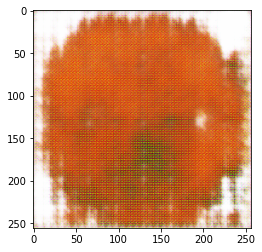

In [44]:

from keras.models import load_model

model = load_model('generator_model_350.h5')
vector = np.asarray([[0.3125757 for _ in range(256)]])

x= model.predict(vector)
x = (x+1)/2
print("Generated Image")
pyplot.imshow(x[0,:,:])
pyplot.show